In [1]:
!pip install qiskit

     |████████████████████████████████| 6.1 MB 8.3 MB/s 
     |████████████████████████████████| 17.9 MB 107 kB/s 
     |████████████████████████████████| 235 kB 56.6 MB/s 
     |████████████████████████████████| 207 kB 52.4 MB/s 
     |████████████████████████████████| 2.1 MB 36.2 MB/s 
     |████████████████████████████████| 200 kB 57.1 MB/s 
     |████████████████████████████████| 634 kB 51.8 MB/s 
     |████████████████████████████████| 1.4 MB 42.0 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 943 kB 53.3 MB/s 
     |████████████████████████████████| 38.2 MB 20 kB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 3.0 MB 35.9 MB/s 
     |████████████████████████████████| 6.3 MB 39.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.30.0-py3-none-any.whl size=11273 sha256=f1e25fdd86d239d244afb3eb4b61ee4bd1680b37e50b6ca3b556caaec515749c
  Stored in directory: /root/.cache/pip/whe

# Problem Statement
**Given/Input**
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
List of integers. Example - [1, 5, 7, 10]

**What is required**

Construct a quantum circuit that identifies those indices `i` such that the binary string of `A[i]` where no two consecutive bits in `A[i]` are the same

For example, i= 0 is should not be selected as  `A[i] = 1` has binary representation `0001` which has 3 consecutive 0s. But, i = 2 is a candidate `5` with binary representation  `0101` does not have any consecutive bits that are same.

**Expected Ouput**

The circuit should output an equal superposition of the candidate indices. In the above example, the circuit must output: $\frac{1}{\sqrt{2}}(\ket{01} + \ket{11})$

# QRAM based approach

<Explain in detail as to what I am doing>


In [119]:
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, QuantumCircuit, AncillaRegister, ClassicalRegister
from qiskit import Aer, assemble, transpile
from qiskit.visualization import plot_histogram
import math

In [53]:
####################################################################
#####                                                          #####
#####                  QRAM Module                             #####
#####                                                          #####
####################################################################


# QROM circuit
def construct_QROM_circuit(data_size, addr_size, data_to_load):
  # Create Quantum Registers for address, output data and routing Qubits
  addr_qubits = QuantumRegister(addr_size, 'addr_qr')
  data_out_qubits = QuantumRegister(data_size, 'data_qr')
  routing_qubits = AncillaRegister(2 ** addr_size, 'route_qr')

  # Create quantum circuit using these registers
  qrom_circuit = QuantumCircuit(addr_qubits, data_out_qubits, routing_qubits)
  qrom_circuit.x(routing_qubits[0]) # Set the first qubit to 1
  
  # Setup memory registers
  mem_register = list()
  n_items = len(data_to_load)
  for i in range(0, n_items):
    mem_qubits = QuantumRegister(data_size, 'mem_' + str(i))
    qrom_circuit.add_register(mem_qubits)
    mem_register.append(mem_qubits) # To access later

    data = data_to_load[i]
    # Load data onto the register
    for j in range(0, len(data)):
      if data[j] == '1':
        qrom_circuit.x(mem_qubits[j])

  # Logic to one-hot encode routing_qubits based on address qubits 
  for i in range(0, addr_size):
    if i == 0:
      qrom_circuit.cx(addr_qubits[-1], routing_qubits[1])
      qrom_circuit.cx(routing_qubits[1], routing_qubits[0])
    else:
      for j in range(0, 2**i):
        qrom_circuit.ccx(addr_qubits[addr_size - 1 - i], routing_qubits[j], routing_qubits[2**i + j])
      for j in range(0, 2**i):
        qrom_circuit.cx(routing_qubits[2**i + j], routing_qubits[j])
  

  # Logic to copy selected content to output register
  for i in range(0, len(mem_register)):
    mem_qubits = mem_register[i]
    for j in range(0, data_size):
      qrom_circuit.ccx(routing_qubits[i], mem_qubits[j], data_out_qubits[j])

  # Uncompute one-hot encoding on auxillary qubits
  for i in range(addr_size - 1, -1, -1):
    if i == 0:
      qrom_circuit.cx(routing_qubits[1], routing_qubits[0])
      qrom_circuit.cx(addr_qubits[addr_size - 1 - i], routing_qubits[1])
    else:
      for j in range(2**i -1, -1, -1):
        qrom_circuit.cx(routing_qubits[2**i + j], routing_qubits[j])
      for j in range(2**i -1, -1, -1):
        qrom_circuit.ccx(addr_qubits[addr_size - 1 - i], routing_qubits[j], routing_qubits[2**i + j])

  return qrom_circuit

In [55]:
# BEGIN: QRAM/QROM Test Block
# Test: QROM circuit - Circuit diagram
qrom_circ = construct_QROM_circuit(1, 1, ['1', '0'])
qrom_circ.draw()

addr_qr_0: ───────■────────────────────────■──
                   │       ┌───┐┌───┐       │  
 data_qr_0: ───────┼───────┤ X ├┤ X ├───────┼──
            ┌───┐  │  ┌───┐└─┬─┘└─┬─┘┌───┐  │  
route_qr_0: ┤ X ├──┼──┤ X ├──■────┼──┤ X ├──┼──
            └───┘┌─┴─┐└─┬─┘  │    │  └─┬─┘┌─┴─┐
route_qr_1: ─────┤ X ├──■────┼────■────■──┤ X ├
            ┌───┐└───┘       │    │       └───┘
   mem_0_0: ┤ X ├────────────■────┼────────────
            └───┘                 │            
   mem_1_0: ──────────────────────■────────────

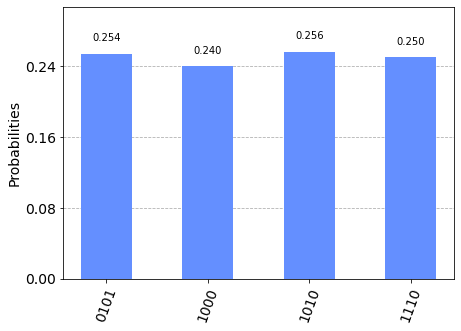

In [60]:
# Test: Memory register circuit - Simulation
data_bits = ClassicalRegister(4) # To store measurement output

# A test circuit to contains QRAM circuit
q_wires = QuantumRegister(26, 'qbs') # For input qubits
test_circ1 = QuantumCircuit(q_wires)

# Generating an equal superposition of all addresses
test_circ1.h(0)
test_circ1.h(1)

qrom_circ = construct_QROM_circuit(4, 2, ['0001', '0101', '0111', '1010'])


test_circ1.append(qrom_circ.to_instruction(), q_wires)
test_circ1.add_register(data_bits)
test_circ1.measure(q_wires[2:6], data_bits) # Measure the data out register



sim = Aer.get_backend('aer_simulator')
circ = transpile(test_circ1, sim)

result = sim.run(circ).result()
count = result.get_counts()
plot_histogram(count)

# END: QRAM/QROM Test block

In [61]:
######################################################################
#####                                                            #####
#####                  Search Oracle                             #####
#####                                                            #####
######################################################################

def construct_search_oracle(data_size):
  data_qubits = QuantumRegister(data_size, name='dt_qr')
  aux_out_qubits = AncillaRegister(data_size -1, name='ax_qr')
  output_qubit = QuantumRegister(1, name='op_qr')
  # Create a circuit for the search oracle
  search_oracle = QuantumCircuit(data_qubits, aux_out_qubits, output_qubit)

  # As Qubit[2 * data_size -1] is our output qubit, set it to |-> state
  search_oracle.x(output_qubit[0])
  search_oracle.h(output_qubit[0])

  # Actual computation: For every pair, of bits, do cx onto intermediate output state
  for i in range(0, data_size - 1):
    search_oracle.cx(i, data_size + i)
    search_oracle.cx(i+1, data_size + i)

  # Store final result in output qubit
  search_oracle.mct(aux_out_qubits, output_qubit)

  # Uncompute
  for i in range(data_size -1 , 0, -1):
    search_oracle.cx(i, data_size - 1 + i)
    search_oracle.cx(i - 1, data_size -1 + i)

  search_oracle.x(output_qubit[0])
  search_oracle.h(output_qubit[0])

  return search_oracle


In [62]:
# BEGIN: Search Oracle Test Block

# Test: Search Oracle - circuit diagram
construct_search_oracle(2).draw()

dt_qr_0: ──■───────────────────■──
           │                   │  
dt_qr_1: ──┼────■─────────■────┼──
         ┌─┴─┐┌─┴─┐     ┌─┴─┐┌─┴─┐
ax_qr_0: ┤ X ├┤ X ├──■──┤ X ├┤ X ├
         ├───┤├───┤┌─┴─┐├───┤├───┤
op_qr_0: ┤ X ├┤ H ├┤ X ├┤ X ├┤ H ├
         └───┘└───┘└───┘└───┘└───┘

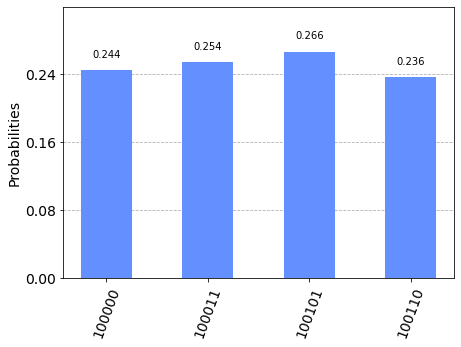

In [63]:
# Test: Search Oracle circuit - Simulation

# A test circuit to contains QRAM circuit
q_wires = QuantumRegister(6, 'qbs') # For input qubits
test_circ2 = QuantumCircuit(q_wires)

# Generating an equal superposition of all 4-bit data values
test_circ2.h(0)
test_circ2.h(1)
test_circ2.h(2)

search_oracle_circ = construct_search_oracle(3)

test_circ2.append(search_oracle_circ.to_instruction(), q_wires)

test_circ2.h(0)
test_circ2.h(1)
test_circ2.h(2)

test_circ2.measure_all()

sim = Aer.get_backend('aer_simulator')
circ = transpile(test_circ2, sim)

result = sim.run(circ).result()
count = result.get_counts()
plot_histogram(count)

# END: Search Oracle Test Block

In [102]:
######################################################################
#####                                                            #####
#####                  Diffuser Operation                        #####
#####                                                            #####
######################################################################

def construct_diffuser_circuit(register_size):
  diff_inputs = QuantumRegister(register_size, "inp")
  diffuser_qc = QuantumCircuit(diff_inputs)

  for i in range(0, register_size):
    diffuser_qc.h(diff_inputs[i])
  for i in range(0, register_size):
    diffuser_qc.x(diff_inputs[i])

  # Controlled - Z rotation as H-CNOT-H
  diffuser_qc.h(diff_inputs[0])
  diffuser_qc.mct(diff_inputs[1:register_size], diff_inputs[0])
  diffuser_qc.h(diff_inputs[0])

  for i in range(0, register_size):
    diffuser_qc.x(diff_inputs[i])
  for i in range(0, register_size):
    diffuser_qc.h(diff_inputs[i])
    
  return diffuser_qc

In [138]:
# Combining all pieces together to produce final circuit

def construct_solution_circuit(data_size, addr_size, input_data):
  # Pre-processing - convert integer to binary
  # Basic error handling:
  # - Check if input_data is none
  # - Check if data_size, addr_size > 0
  # - Check if len(input_data) == 2**addr_size
  if data_size <= 0 or addr_size <= 0 or input_data is None or len(input_data) != (2 ** addr_size):
    raise ValueError
  
  # Convert input integer to bitstring
  bin_data = list()
  bin_str_frmtr = "{" + "0:0{}".format(data_size) + "b}"
  for integer in input_data:
    bin_data.append(bin_str_frmtr.format(integer))

  # Create Quantum Registers to be used the circuit
  circuit_qubits = QuantumRegister(addr_size + data_size
                                + 2**addr_size + data_size*len(bin_data), "qbs")

  # Create QROM, search and diffuser circuits
  qrom_circ = construct_QROM_circuit(data_size, addr_size, bin_data)
  search_oracle = construct_search_oracle(data_size)
  diffuser = construct_diffuser_circuit(data_size)

  # Create quantum circuit with QROM and oracle as sub-circuits
  solution_qc = QuantumCircuit(circuit_qubits)

  #Put address qubits in equal superposition
  for i in range(0, addr_size):
    solution_qc.h(circuit_qubits[i])
  
  # Add memory circuit to solution circuit
  qrom_circ_inst = qrom_circ.to_instruction()
  solution_qc.append(qrom_circ_inst, circuit_qubits)

  # Add search oracle to solution circuit
  search_qubits = circuit_qubits[addr_size : addr_size + 2*data_size]
  search_oracle_inst = search_oracle.to_instruction()
  solution_qc.append(search_oracle_inst, search_qubits)
  # Add diffuser circuit
  solution_qc.append(diffuser.to_instruction(), circuit_qubits[addr_size : addr_size + data_size])

  for i in range(1, int(math.sqrt(2 ** (addr_size)))):
    solution_qc.append(search_oracle_inst, search_qubits)
    solution_qc.append(diffuser.to_instruction(), circuit_qubits[addr_size : addr_size + data_size])

  # Build and return final circuit
  return solution_qc

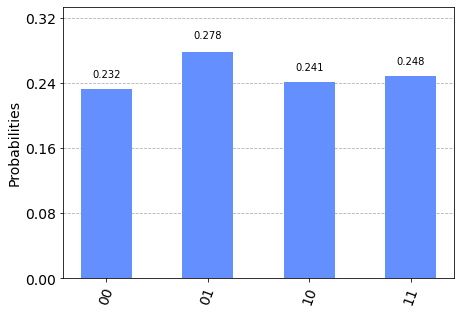

In [139]:
# Test Search circuit
data_bits = ClassicalRegister(2) # To store measurement output

# A test circuit to contains QRAM circuit
q_wires = QuantumRegister(26, 'qbs') # For input qubits
test_circ4 = QuantumCircuit(q_wires)

soln_circ = construct_solution_circuit(4, 2, [1, 5, 7, 10])


test_circ4.append(soln_circ.to_instruction(), q_wires)
test_circ4.add_register(data_bits)
test_circ4.measure(q_wires[0:2], data_bits) # Measure the data out register

sim = Aer.get_backend('aer_simulator')
circ = transpile(test_circ4, sim)

result = sim.run(circ).result()
count = result.get_counts()
plot_histogram(count)

# Learnings (and points for further exploration)
- Can the same problem be solved with a non-QRAM approach (say by performing basis-encoding or amplitude encoding of data onto quantum states)?
   - [Naive analysis] If the overall solution to identify the indices is Grover'search, then non-QRAm approaches may not really work. Afterall, there is no way we can get the oracle to work on the amplitude directly instead of the state ket

- The current implementation make use of a lot of CNOT gates. It would be nice to explore if we can make the implementation less CNOT heavy 

- Alternative QRAM architectures?
